# PanNuke.ipynb

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image, ImageOps
import os
import sys
from pathlib import Path
from math import inf
from tqdm import tqdm

from torchvision.transforms import Compose, ToPILImage, ToTensor
import torch

top_folder = str(Path(os.getcwd()).parent.parent)
sys.path.append(top_folder)

os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

#%matplotlib widget

In [2]:
from src.vizualizations.image_viz import plot_images

In [3]:
fold_path = os.path.join(top_folder, 'data/raw/unzipped/PanNuke/Fold 3')

## Inspecting Images

In [4]:
img_data = (np.load(os.path.join(fold_path, 'images','fold3','images.npy')))


In [5]:
img_data = img_data.astype(np.uint8)
print(img_data.dtype)
print(img_data[0].max(),img_data[1].min())
print(img_data.shape)

uint8
255 24
(2722, 256, 256, 3)


This is very intersting. The `.npy` says that it is 4GB large, but since each pixel is actually just 1 byte, the file should be closer to 500MB. It is my belief that pixels are stored as 8 byte floating points without actually making use of that extra precision. Hence, to save space, I will be converting all these images down to 8bits.

In [6]:
types_data = np.load(os.path.join(fold_path, 'images','fold3','types.npy'))
print(types_data)

['Breast' 'Breast' 'Breast' ... 'Colon' 'Colon' 'Colon']


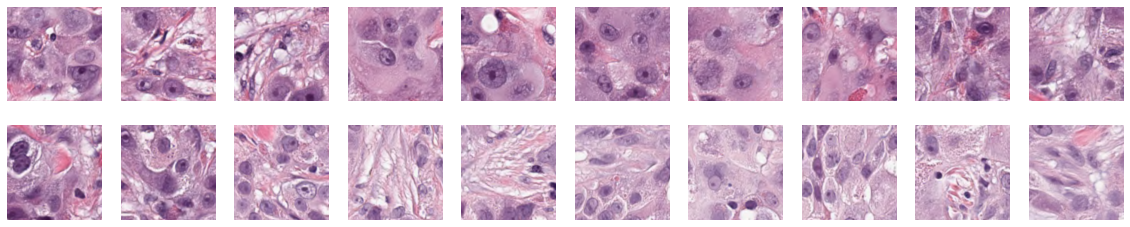

In [7]:
examples = img_data[:20]
plot_images(examples, (2,10))
plt.show()

In [8]:
del img_data

In [9]:
mask_data = (np.load(os.path.join(fold_path, 'masks','fold3','masks.npy')))


In [10]:
mask_data = mask_data.astype(np.uint8)
print(mask_data.dtype)
print(mask_data[0].max(),mask_data[1].min())
print(mask_data.shape)

uint8
160 0
(2722, 256, 256, 6)


Interesting. Same mistake. There are 6 channels, 1 for the 5 types of cells recorded + 1 for background. Each value represents an instance id, and among all images in all folds, the max is less than 200 so we can store safely this in a 6

uint8
0 160


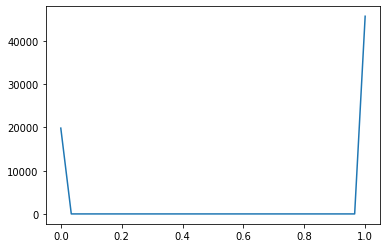

In [11]:
from src.vizualizations.tensor_viz import plot_tensor_histogram

sample = mask_data[:5,:,:,:].transpose(0,3,1,2)
print(sample.dtype)
sample = np.reshape(sample, (-1,256,256), order='C')

plot_tensor_histogram(sample[5], bins=30)
print(sample.min(), sample.max())
plt.show()



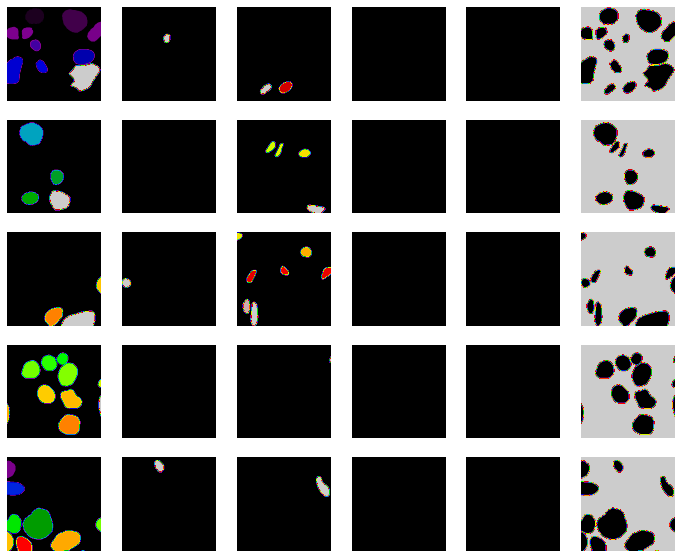

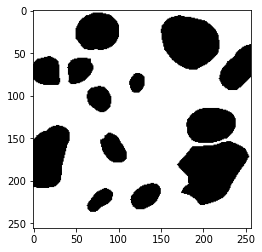

In [12]:
plot_images(sample,(5,6))
plt.show()
plt.imshow(sample[5],cmap="gray")
plt.show()

I was wrong. I do not think the last channel is for the background. Instead, I think it is for creating a mask for all the cell types. I shall process this last channel to derive the masks I am interested in. Also, the multi-colour effect is because of anti-aliasing I think. When you zoom in, they disappear. So actually, the image is just black and white, so can do simple **percolation algorithm**

In [13]:
#from src.utilities.os_utilities import create_dir_if_not_exist
#savefolder = os.path.join(top_folder,"tests","data","images")
#create_dir_if_not_exist(savefolder)
#np.save(os.path.join(savefolder,"test_island_identifier.npy"),sample[5])

In [14]:
from src.transforms.percolation import island_identifier

instance_segmented = island_identifier(sample[5])

13
0


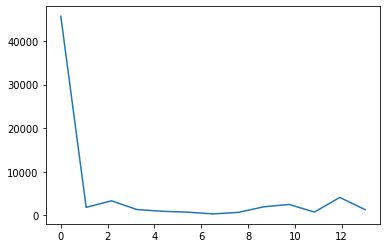

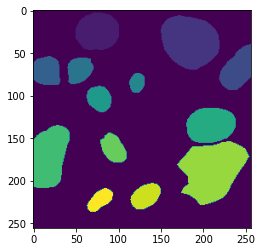

In [18]:
instance_segmented = island_identifier(sample[5])
print(instance_segmented.max())
print(instance_segmented.min())
plot_tensor_histogram(instance_segmented, bins=13)
plt.figure()
plt.imshow(instance_segmented)
plt.show()

# Collect all images into 1 numpy file

In [20]:
def collect_images():
    fold_path = os.path.join(top_folder, 'data/raw/unzipped/PanNuke')
    f1,f2,f3 = os.path.join(fold_path,"Fold 1","images","fold1","images.npy"),os.path.join(fold_path,"Fold 2","images","fold2","images.npy"),os.path.join(fold_path,"Fold 3","images","fold3","images.npy")
    a1 = np.load(f1).astype(np.uint8)
    a2 = np.load(f2).astype(np.uint8)
    a3 = np.load(f3).astype(np.uint8)
    return np.concatenate([a1,a2,a3],axis=0)

arr = collect_images()
print(arr.shape)

(7901, 256, 256, 3)
